In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.preprocessing.sequence import TimeseriesGenerator
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings

warnings.filterwarnings("ignore")

In [48]:
df = pd.read_csv('C:/Users/shail/Desktop/standarddataset/AirPassengers.csv', index_col='Month', parse_dates=True)
df.index.freq='MS'

In [49]:
df.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


<AxesSubplot:xlabel='Month'>

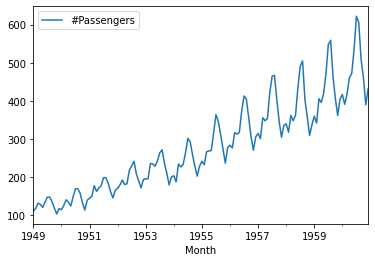

In [50]:
df.plot()

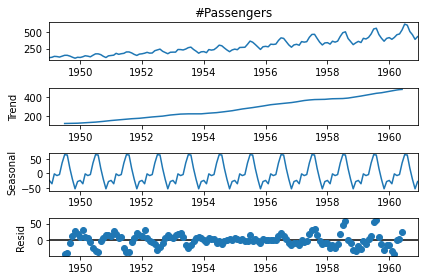

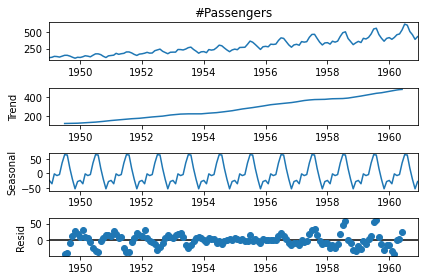

In [51]:
results = seasonal_decompose(df['#Passengers'])
results.plot()

In [52]:
len(df)

144

In [53]:
train = df.iloc[:132]
test = df.iloc[132:]

scaler = MinMaxScaler()

In [54]:
df.head(), df.tail()

(            #Passengers
 Month                  
 1949-01-01          112
 1949-02-01          118
 1949-03-01          132
 1949-04-01          129
 1949-05-01          121,
             #Passengers
 Month                  
 1960-08-01          606
 1960-09-01          508
 1960-10-01          461
 1960-11-01          390
 1960-12-01          432)

In [55]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

scaled_train[:10]

array([[0.01758242],
       [0.03076923],
       [0.06153846],
       [0.05494505],
       [0.03736264],
       [0.06813187],
       [0.0967033 ],
       [0.0967033 ],
       [0.07032967],
       [0.03296703]])

# Recursive Strategy

In [59]:
n_input = 12
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train,length=n_input,batch_size=1)

generator[0]

(array([[[0.01758242],
         [0.03076923],
         [0.06153846],
         [0.05494505],
         [0.03736264],
         [0.06813187],
         [0.0967033 ],
         [0.0967033 ],
         [0.07032967],
         [0.03296703],
         [0.        ],
         [0.03076923]]]),
 array([[0.02417582]]))

In [60]:
model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "sequential_74"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_74 (LSTM)               (None, 200)               161600    
_________________________________________________________________
dense_74 (Dense)             (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________


In [61]:
model.fit(generator, epochs=50, verbose=0)

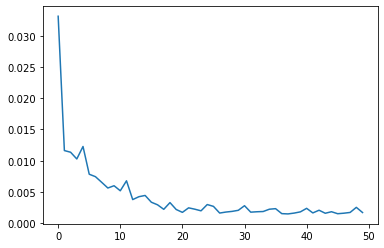

In [62]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)), loss_per_epoch)

In [63]:
last_train_batch = scaled_train[-n_input:]

last_train_batch = last_train_batch.reshape((1,n_input, n_features))

model.predict(last_train_batch)

array([[0.5884037]], dtype=float32)

In [64]:
scaled_test[0], scaled_test[1]

(array([0.68791209]), array([0.63076923]))

In [65]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    current_pred = model.predict(current_batch)[0]
    
    test_predictions.append(current_pred)
    
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]], axis=1)
    
test_predictions

[array([0.5884037], dtype=float32),
 array([0.5801239], dtype=float32),
 array([0.65149885], dtype=float32),
 array([0.6711217], dtype=float32),
 array([0.7371684], dtype=float32),
 array([0.8849613], dtype=float32),
 array([1.047644], dtype=float32),
 array([1.0678515], dtype=float32),
 array([0.88069993], dtype=float32),
 array([0.7231112], dtype=float32),
 array([0.6424544], dtype=float32),
 array([0.6536106], dtype=float32)]

In [66]:
test.head()

,#Passengers
Month,
1960-01-01,417
1960-02-01,391
1960-03-01,419
1960-04-01,461
1960-05-01,472


In [67]:
true_predictions = scaler.inverse_transform(test_predictions)

test['recursive_predict'] = true_predictions

<AxesSubplot:xlabel='Month'>

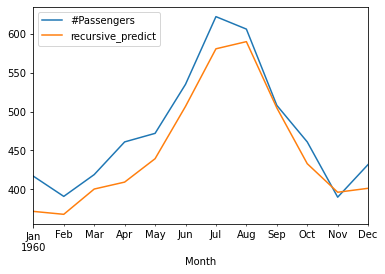

In [68]:
test.plot()

In [69]:
rmse = sqrt(mean_squared_error(test['#Passengers'], test['recursive_predict']))
print(rmse)

30.54488581787056


In [70]:
test

,#Passengers,recursive_predict
Month,,
1960-01-01,417,371.723684
1960-02-01,391,367.956375
1960-03-01,419,400.431979
1960-04-01,461,409.360381
1960-05-01,472,439.411609
1960-06-01,535,506.657395
1960-07-01,622,580.678029
1960-08-01,606,589.872452
1960-09-01,508,504.718469


# Direct Startegy

In [71]:
def generate_data(data, n_input, month):
    X, y = [], []
    for i in range(0,len(data)-(n_input+month)):
            X.append(data[i:i+n_input])
            y.append(data[i+n_input+(month-1)])
    return np.array(X), np.array(y)

In [72]:
def model_predict(m_no, train_data, n_input, n_features):
    
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    
    X, y = generate_data(train_data, n_input, m_no)
    
    #print("MODEL : ", m_no)
    #print(X[0], y[0])
    
    model.fit(X, y, epochs=50, verbose=0)
    
    tX = train_data[-n_input:]
    
    tX = tX.reshape((1, n_input, n_features))
    
    res = model.predict(tX)
    
    return res[0]

In [73]:
n_input = 12
n_features = 1
test_predictions = []

for i in range(len(scaled_test)):
    test_predictions.append(model_predict(i+1,scaled_train,n_input, n_features))
    
test_predictions

[array([0.60448796], dtype=float32),
 array([0.6656652], dtype=float32),
 array([0.6570134], dtype=float32),
 array([0.679831], dtype=float32),
 array([0.8976846], dtype=float32),
 array([1.0356985], dtype=float32),
 array([1.0216014], dtype=float32),
 array([1.0121651], dtype=float32),
 array([0.9104717], dtype=float32),
 array([0.79046214], dtype=float32),
 array([0.7317418], dtype=float32),
 array([0.7166336], dtype=float32)]

In [74]:
true_predictions = scaler.inverse_transform(test_predictions)

test['direct_predict'] = true_predictions

<AxesSubplot:xlabel='Month'>

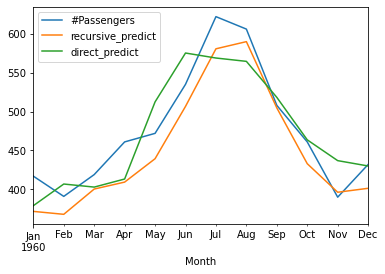

In [75]:
test.plot()

In [76]:
rmse = sqrt(mean_squared_error(test['#Passengers'], test['direct_predict']))
print(rmse)

34.575503111645794


In [77]:
test

,#Passengers,recursive_predict,direct_predict
Month,,,
1960-01-01,417,371.723684,379.042020
1960-02-01,391,367.956375,406.877670
1960-03-01,419,400.431979,402.941104
1960-04-01,461,409.360381,413.323118
1960-05-01,472,439.411609,512.446481
1960-06-01,535,506.657395,575.242833
1960-07-01,622,580.678029,568.828655
1960-08-01,606,589.872452,564.535107
1960-09-01,508,504.718469,518.264613


# Direct Recursive Startegy

In [78]:
def generate_data(data, n_input, month):
    X, y = [], []
    for i in range(0,len(data)-(n_input+month)):
            X.append(data[i:i+n_input+(month-1)])
            y.append(data[i+n_input+(month-1)])
    return np.array(X), np.array(y)

In [79]:
def model_predict(m_no, train_data, n_input, n_features):
    
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_input+(m_no - 1), n_features)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    
    X, y = generate_data(train_data, n_input, m_no)
    #print(y.dtype)
    
    #print("Model No.  - ", m_no)
    #print(X[0], y[0])
    #print("SHAPE XY : ", X.shape, y.shape)
    
    model.fit(X, y, epochs=50, verbose=0)
    
    tX = train_data[-n_input:]
    tP = np.array(test_predictions)
    
    tX = np.concatenate((tX, tP), axis=None)
    
    #print("TYPE : ", type(tX), type(tP))
    
    #print("TX : ", tX)
        
    #print("SHAPE : " , tX.shape)
    
    tX = tX.reshape((1, tX.shape[0], n_features))
    
    res = model.predict(tX)
    
    return res[0]

In [80]:
n_input = 12
n_features = 1
test_predictions = []

for i in range(len(scaled_test)):
    pred = model_predict(i+1,scaled_train,n_input, n_features)
    test_predictions.append(pred)
    
test_predictions

[array([0.5634977], dtype=float32),
 array([0.6790568], dtype=float32),
 array([0.744306], dtype=float32),
 array([0.8158196], dtype=float32),
 array([0.9477992], dtype=float32),
 array([0.849396], dtype=float32),
 array([0.8459381], dtype=float32),
 array([0.986297], dtype=float32),
 array([0.88094735], dtype=float32),
 array([0.86987543], dtype=float32),
 array([0.8584455], dtype=float32),
 array([0.8297039], dtype=float32)]

In [81]:
true_predictions = scaler.inverse_transform(test_predictions)

test['direct_recursive_predict'] = true_predictions

<AxesSubplot:xlabel='Month'>

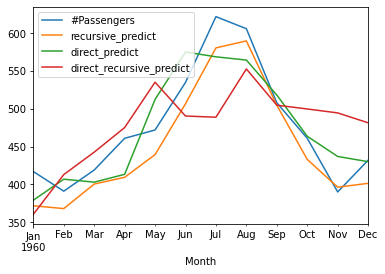

In [82]:
test.plot()

In [83]:
rmse = sqrt(mean_squared_error(test['#Passengers'], test['direct_recursive_predict']))
print(rmse)

61.83773985317238


In [84]:
test

,#Passengers,recursive_predict,direct_predict,direct_recursive_predict
Month,,,,
1960-01-01,417,371.723684,379.042020,360.391464
1960-02-01,391,367.956375,406.877670,412.970855
1960-03-01,419,400.431979,402.941104,442.659243
1960-04-01,461,409.360381,413.323118,475.197928
1960-05-01,472,439.411609,512.446481,535.248639
1960-06-01,535,506.657395,575.242833,490.475176
1960-07-01,622,580.678029,568.828655,488.901829
1960-08-01,606,589.872452,564.535107,552.765140
1960-09-01,508,504.718469,518.264613,504.831045


# MIMO

In [85]:
def generate_data(data, n_input):
    X, y = [], []
    for i in range(0,len(data)-(n_input*2)):
            X.append(data[i:(i+n_input)])
            y.append(data[i+n_input: i+n_input+n_input])
    return np.array(X), np.array(y)

In [86]:
n_input = 12
n_features = 1
X, y = generate_data(scaled_train, n_input)

In [87]:
model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(n_input))
model.compile(optimizer='adam', loss='mse')

In [88]:
model.fit(X, y, epochs=50, verbose=0)

In [89]:
model.summary()

Model: "sequential_99"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_99 (LSTM)               (None, 200)               161600    
_________________________________________________________________
dense_99 (Dense)             (None, 12)                2412      
Total params: 164,012
Trainable params: 164,012
Non-trainable params: 0
_________________________________________________________________


In [90]:
tX = scaled_train[-n_input:]
tX = tX.reshape((1, tX.shape[0], n_features))

res = model.predict(tX)

res = res.reshape((res.shape[1],1))

In [91]:
res.shape

(12, 1)

In [92]:
true_predictions = scaler.inverse_transform(res)

test['MIMO_predict'] = true_predictions

In [93]:
test

,#Passengers,recursive_predict,direct_predict,direct_recursive_predict,MIMO_predict
Month,,,,,
1960-01-01,417,371.723684,379.042020,360.391464,443.493866
1960-02-01,391,367.956375,406.877670,412.970855,448.720306
1960-03-01,419,400.431979,402.941104,442.659243,460.269287
1960-04-01,461,409.360381,413.323118,475.197928,452.828064
1960-05-01,472,439.411609,512.446481,535.248639,467.645355
1960-06-01,535,506.657395,575.242833,490.475176,463.111694
1960-07-01,622,580.678029,568.828655,488.901829,492.671295
1960-08-01,606,589.872452,564.535107,552.765140,490.315765
1960-09-01,508,504.718469,518.264613,504.831045,490.346405


<AxesSubplot:xlabel='Month'>

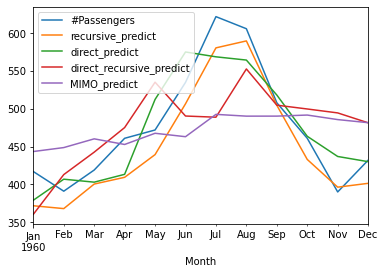

In [94]:
test.plot()

In [95]:
rmse = sqrt(mean_squared_error(test['#Passengers'], test['MIMO_predict']))
print(rmse)

67.07835357772092


# Direct MIMO

In [96]:
def generate_data(data, n_input, q_no):
    X, y = [], []
    for i in range(0,len(data)-(n_input + ((q_no-1)*3) + 3)):
            X.append(data[i:(i+n_input)])
            y.append(data[i+n_input+((q_no-1)*3): i+n_input+((q_no-1)*3) + 3])
    return np.array(X), np.array(y)

In [97]:
def model_predict(train_data, n_input, n_features, q_no):
    
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
    model.add(Dense(3))
    model.compile(optimizer='adam', loss='mse')
    
    X, y = generate_data(train_data, n_input, q_no)
    
    model.fit(X, y, epochs=50, verbose=0)
    
    tX = train_data[-n_input:]
    
    tX = tX.reshape((1, n_input, n_features))
    
    res = model.predict(tX)
    
    return res

In [98]:
n_input = 12
n_features = 1
test_predictions = []

q = int(len(scaled_test)/3)

for i in range(q):
    pred = model_predict(scaled_train,n_input, n_features, i+1)
    test_predictions.append(pred)

test_predictions

[array([[0.6628038 , 0.663807  , 0.66665715]], dtype=float32),
 array([[0.84458184, 0.8583046 , 0.86138487]], dtype=float32),
 array([[1.0667521, 1.0325629, 0.9504834]], dtype=float32),
 array([[0.7351422 , 0.72472906, 0.76638603]], dtype=float32)]

In [99]:
res = []

for i in test_predictions:
    for j in i:
        for k in j:
            res.append(k)

In [100]:
res = np.array(res)
res = res.reshape((res.shape[0],1))
res.shape

(12, 1)

In [101]:
true_predictions = scaler.inverse_transform(res)

test['Direct_MIMO_predict'] = true_predictions

In [102]:
test

,#Passengers,recursive_predict,direct_predict,direct_recursive_predict,MIMO_predict,Direct_MIMO_predict
Month,,,,,,
1960-01-01,417,371.723684,379.042020,360.391464,443.493866,405.575745
1960-02-01,391,367.956375,406.877670,412.970855,448.720306,406.032166
1960-03-01,419,400.431979,402.941104,442.659243,460.269287,407.329010
1960-04-01,461,409.360381,413.323118,475.197928,452.828064,488.284729
1960-05-01,472,439.411609,512.446481,535.248639,467.645355,494.528595
1960-06-01,535,506.657395,575.242833,490.475176,463.111694,495.930115
1960-07-01,622,580.678029,568.828655,488.901829,492.671295,589.372192
1960-08-01,606,589.872452,564.535107,552.765140,490.315765,573.816101
1960-09-01,508,504.718469,518.264613,504.831045,490.346405,536.469971


<AxesSubplot:xlabel='Month'>

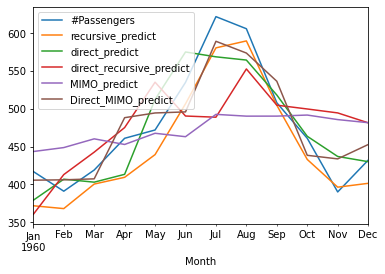

In [103]:
test.plot()

In [104]:
rmse = sqrt(mean_squared_error(test['#Passengers'], test['Direct_MIMO_predict']))
print(rmse)

27.434326608989515


In [108]:
rec_err = abs(test['#Passengers'] - test['recursive_predict'])
dir_err = abs(test['#Passengers'] - test['direct_predict'])
dir_rec_err = abs(test['#Passengers'] - test['direct_recursive_predict'])
mimo_err = abs(test['#Passengers'] - test['MIMO_predict'])
dir_mimo_err = abs(test['#Passengers'] - test['Direct_MIMO_predict'])

In [111]:
errors = pd.DataFrame({
    'Recursive':rec_err,
    'Direct':dir_err,
    'Direct Recursive':dir_rec_err,
    'MIMO':mimo_err,
    'Direct MIMO':dir_mimo_err
})

In [112]:
errors

,Recursive,Direct,Direct Recursive,MIMO,Direct MIMO
Month,,,,,
1960-01-01,45.276316,37.957980,56.608536,26.493866,11.424255
1960-02-01,23.043625,15.877670,21.970855,57.720306,15.032166
1960-03-01,18.568021,16.058896,23.659243,41.269287,11.670990
1960-04-01,51.639619,47.676882,14.197928,8.171936,27.284729
1960-05-01,32.588391,40.446481,63.248639,4.354645,22.528595
1960-06-01,28.342605,40.242833,44.524824,71.888306,39.069885
1960-07-01,41.321971,53.171345,133.098171,129.328705,32.627808
1960-08-01,16.127548,41.464893,53.234860,115.684235,32.183899
1960-09-01,3.281531,10.264613,3.168955,17.653595,28.469971


<AxesSubplot:xlabel='Month'>

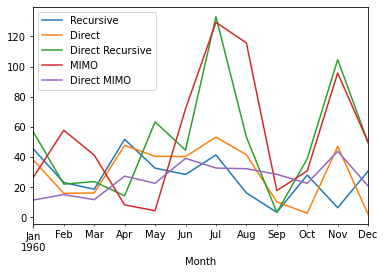

In [114]:
errors.plot()